In [1]:
import torch
from sklearn.model_selection import train_test_split

# ---------------------------
# Load data from disk
# ---------------------------

PATH_TO_SAVED_DYNAMIC_alpha = r'/home/ahmad/Downloads/class0_2_window4_ol0/granger_all_dynamic_data_ol0_window4_alpha.pt'
PATH_TO_SAVED_DYNAMIC_beta  = r'/home/ahmad/Downloads/class0_2_window4_ol0/granger_all_dynamic_data_ol0_window4_beta.pt'

dynamic_data_alpha_raw = torch.load(PATH_TO_SAVED_DYNAMIC_alpha)
dynamic_data_beta_raw  = torch.load(PATH_TO_SAVED_DYNAMIC_beta)

# ---------------------------
# Preprocessing functions
# ---------------------------

def filter_classes(dynamic_data, allowed_classes=[0, 2]):
    return [subj for subj in dynamic_data if len(subj) > 0 and subj[0].y.item() in allowed_classes]

def relabel_class_2_as_1(dynamic_data):
    for subject_list in dynamic_data:
        for graph in subject_list:
            if graph.y.item() == 2:
                graph.y = torch.tensor([1], dtype=torch.long)
    return dynamic_data

def subject_level_stratified_split(dynamic_data, test_size=0.2, random_state=42):
    subject_list = []
    labels = []
    for subj_windows in dynamic_data:
        if len(subj_windows) == 0:
            continue
        label = subj_windows[0].y.item()
        subject_list.append(subj_windows)
        labels.append(label)

    train_list, test_list = train_test_split(
        subject_list,
        test_size=test_size,
        stratify=labels,
        shuffle=True,
        random_state=random_state
    )
    return train_list, test_list

def compute_node_edge_stats(dynamic_data):
    node_features = []
    edge_features = []
    for subject_list in dynamic_data:
        for data_obj in subject_list:
            node_features.append(data_obj.x)
            edge_features.append(data_obj.edge_attr)
    all_node_feats = torch.cat(node_features, dim=0)
    all_edge_feats = torch.cat(edge_features, dim=0)

    node_means = all_node_feats.mean(dim=0)
    node_stds  = all_node_feats.std(dim=0)

    edge_means = all_edge_feats.mean(dim=0)
    edge_stds  = all_edge_feats.std(dim=0)
    return node_means, node_stds, edge_means, edge_stds

def apply_node_edge_standardization(dynamic_data, node_means, node_stds, edge_means, edge_stds):
    for subject_list in dynamic_data:
        for data_obj in subject_list:
            data_obj.x = (data_obj.x - node_means) / (node_stds + 1e-7)
            data_obj.edge_attr = (data_obj.edge_attr - edge_means) / (edge_stds + 1e-7)
    return dynamic_data

def process_band(dynamic_data_band):
    # 1. Filter only class 0 and 2
    filtered_data = filter_classes(dynamic_data_band, allowed_classes=[0, 2])

    # 2. Relabel class 2 to class 1
    filtered_data = relabel_class_2_as_1(filtered_data)

    # 3. Subject-level stratified split
    train_data, test_data = subject_level_stratified_split(filtered_data, test_size=0.2)

    # 4. Compute stats on training subjects only
    node_means, node_stds, edge_means, edge_stds = compute_node_edge_stats(train_data)

    # 5. Normalize train and test sets
    train_data_stand = apply_node_edge_standardization(train_data, node_means, node_stds, edge_means, edge_stds)
    test_data_stand  = apply_node_edge_standardization(test_data,  node_means, node_stds, edge_means, edge_stds)

    # 6. Concatenate normalized sets (optional)
    dynamic_data_stand = train_data_stand + test_data_stand
    return train_data_stand, test_data_stand, dynamic_data_stand

# ---------------------------
# Process each band
# ---------------------------
train_alpha, test_alpha, dynamic_alpha = process_band(dynamic_data_alpha_raw)
train_beta,  test_beta,  dynamic_beta  = process_band(dynamic_data_beta_raw)

# ---------------------------
# Print summary
# ---------------------------
print(f"Alpha band: {len(dynamic_alpha)} subjects")
print(f"Beta band:  {len(dynamic_beta)} subjects")


/tmp/ipykernel_55695/3672586793.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dynamic_data_alpha_raw = torch.load(PATH_TO_SAVED_DYNAMIC_alpha)
/tmp/ipykernel_55695/36

Alpha band: 65 subjects
Beta band:  65 subjects


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm
import numpy as np
from torch_geometric.nn import SAGEConv

In [3]:


class BandSpecificGraphSAGE(nn.Module):
    """Process a single band's sequence of temporal graphs"""
    def __init__(self, in_channels=18, hidden_channels=64 #64
    , dropout_rate=0.5, num_nodes=19):
        super().__init__()
        self.dropout_rate = dropout_rate
        self.hidden_channels = hidden_channels
        self.num_nodes = num_nodes
        
        # GraphSAGE layers for spatial feature extraction
        self.sage1 = SAGEConv(in_channels, hidden_channels)
        self.bn1 = nn.BatchNorm1d(hidden_channels)
        self.sage2 = SAGEConv(hidden_channels, hidden_channels)
        self.bn2 = nn.BatchNorm1d(hidden_channels)
        
        # Temporal processing
        self.lstm = nn.LSTM(
            input_size=hidden_channels * num_nodes,
            hidden_size=hidden_channels,
            num_layers=2,
            batch_first=True,
            bidirectional=True,
            dropout= 0.0 #if 2 > 1 else 0
        )
        
        # Attention for temporal features
        self.temporal_attention = nn.Linear(hidden_channels * 2, 1)
        
        # Normalization and dropout
        self.layer_norm1 = nn.LayerNorm(hidden_channels)
        self.layer_norm2 = nn.LayerNorm(hidden_channels * 2)
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, graphs):
        seq_embs = []
        for graph in graphs:
            # First GraphSAGE layer
            x = self.sage1(graph.x, graph.edge_index)
            x = self.bn1(x)
            x = F.relu(x)
            x = self.layer_norm1(x)
            if self.training:
                x = self.dropout(x)
            
            # Second GraphSAGE layer
            x = self.sage2(x, graph.edge_index)
            x = self.bn2(x)
            x = F.relu(x)
            if self.training:
                x = self.dropout(x)
            
            # Flatten for temporal processing
            x_flat = x.reshape(1, -1)
            seq_embs.append(x_flat)
        
        if len(seq_embs) > 0:
            seq_tensor = torch.cat(seq_embs, dim=0).unsqueeze(0)
            lstm_out, _ = self.lstm(seq_tensor)
            
            # Apply temporal attention
            lstm_out = self.layer_norm2(lstm_out)
            attn_weights = F.softmax(self.temporal_attention(lstm_out).squeeze(-1), dim=1)
            attn_applied = torch.bmm(attn_weights.unsqueeze(1), lstm_out)
            output = attn_applied.squeeze(1)  # Shape: [1, hidden_channels*2]
            return output
        else:
            device = next(self.parameters()).device
            return torch.zeros(1, self.hidden_channels * 2, device=device)

class MultiBandAttentionFusion(nn.Module):
    """Fusion model with improved multi-head attention for band fusion"""
    def __init__(self, num_bands=5, hidden_channels=64, num_classes=2, dropout_rate=0.5, num_nodes=19, in_channels=18):
        super().__init__()
        self.num_bands = num_bands
        self.hidden_channels = hidden_channels

        self.band_processors = nn.ModuleList()
        for band_idx in range(num_bands):
            self.band_processors.append(
                BandSpecificGraphSAGE(in_channels, hidden_channels, dropout_rate, num_nodes)
            )
        
        self.band_projection = nn.Linear(hidden_channels * 2, hidden_channels * 2)
        self.band_attention = nn.Linear(hidden_channels * 2, 1)
        self.layer_norm = nn.LayerNorm(hidden_channels * 2)

        self.fc1 = nn.Linear(hidden_channels * 2, hidden_channels)
        self.fc2 = nn.Linear(hidden_channels, num_classes)
        self.dropout = nn.Dropout(dropout_rate)

        self.band_weights_history = []
        self.l1_factor = 0.05 #0.01
    
    def forward(self, subjects_data):
        all_outputs = []
        all_band_weights = []
        
        for subject in subjects_data:
            band_features = []
            
            for band_idx, band_graphs in enumerate(subject):
                band_output = self.band_processors[band_idx](band_graphs)
                band_output = self.band_projection(band_output)
                band_features.append(band_output)
            
            band_features = torch.cat(band_features, dim=0)  # [num_bands, hidden_channels*2]
            num_bands = band_features.shape[0]

            attention_logits = self.band_attention(band_features).squeeze(-1)
            attention_weights = F.softmax(attention_logits, dim=0)
            
            attended_features = torch.zeros_like(band_features[0]).unsqueeze(0)
            for i in range(num_bands):
                attended_features += band_features[i].unsqueeze(0) * attention_weights[i]
            
            all_band_weights.append(attention_weights.detach().cpu())

            fused_features = self.layer_norm(attended_features)
            out = self.fc1(fused_features)
            out = F.relu(out)
            if self.training:
                out = self.dropout(out)
            out = self.fc2(out)

            if self.training and self.l1_factor > 0:
                l1_loss = self.l1_factor * torch.abs(attention_weights - 1.0 / num_bands).sum()
                self.l1_loss = l1_loss

            all_outputs.append(out)
        
        if self.training:
            self.band_weights_history.append(torch.stack(all_band_weights).mean(dim=0))
        
        return torch.cat(all_outputs, dim=0)
    def get_band_importance(self):
        """Returns the average attention weight for each band over the training history"""
        if not self.band_weights_history:
            return None

        all_weights = torch.stack(self.band_weights_history)  # shape: [num_epochs, num_bands]
        mean_weights = all_weights.mean(dim=0)  # shape: [num_bands]
        return mean_weights.cpu().numpy()    


using multi head attentoin for band importance

second netwrok

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.nn import GATConv
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.nn import GATConv
from torch_geometric.data import Data
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, f1_score, recall_score, precision_score, accuracy_score
from tqdm import tqdm
import copy
import numpy as np
from sklearn.metrics import confusion_matrix
from torch_geometric.nn import SAGEConv

In [5]:




def train_with_cross_validation(dataset, num_epochs=100, n_folds=5, band_names=None):
    """Train model with stratified k-fold cross validation and analyze band importance"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Set default band names if not provided
    if band_names is None:
        band_names = [f"Band {i+1}" for i in range(len(dataset[0]))]
    
    # Define minimum improvement threshold for tracking best model
    min_delta = 0.001  # Minimum change in validation F1 to be considered an improvement
    
    # Get labels for stratification
    # Collect labels for each subject (assuming all bands are aligned)
    labels = [subject[0][0].y.item() for subject in dataset]





    
    # Initialize stratified k-fold
    from sklearn.model_selection import StratifiedKFold
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    # Track metrics across folds
    all_fold_metrics = []
    all_band_importances = []
    fold_models = []  # Store models from each fold for potential ensemble
    
    fold_idx = 1
    
    # Track best model across all folds
    best_overall_f1 = 0
    best_overall_metrics = None
    best_overall_model_state = None
    
    for train_idx, val_idx in skf.split(range(len(labels)), labels):
        print(f"\n===== Fold {fold_idx}/{n_folds} =====")
        
        # Split data
        train_data = [dataset[i] for i in train_idx]
        val_data = [dataset[i] for i in val_idx]
        
        # Report class distribution
        def count_classes(data):
            class0 = sum(1 for subject in data if subject[0][0].y.item() == 0)
            return class0, len(data) - class0
        
        class0_count, class1_count = count_classes(train_data)
        print(f"Training set: Class 0: {class0_count}, Class 1: {class1_count}")
        
        class0_count, class1_count = count_classes(val_data)
        print(f"Validation set: Class 0: {class0_count}, Class 1: {class1_count}")
        
        # Initialize model for this fold with proper weight initialization
        num_bands = len(dataset[0])
        num_nodes = dataset[0][0][0].x.size(0)
        in_channels = dataset[0][0][0].x.size(1)
        

        
        # Try multiple initializations and select the best one
        best_init_loss = float('inf')
        best_init_model = None
        
        for init_attempt in range(3):  # Try 3 different initializations
            # Initialize model with Xavier/Glorot initialization
            temp_model = MultiBandAttentionFusion(
                num_bands=num_bands, 
                hidden_channels=64, 
                num_classes=2, 
                dropout_rate=0.5,  # Keep moderate dropout 
                num_nodes=num_nodes,
                in_channels=in_channels
            ).to(device)
            
            # Apply Xavier/Glorot initialization to all linear layers
            for module in temp_model.modules():
                if isinstance(module, nn.Linear):
                    nn.init.xavier_uniform_(module.weight)
                    if module.bias is not None:
                        nn.init.zeros_(module.bias)
            
            # Quick validation to select best initialization
            temp_model.eval()
            init_loss = 0
            with torch.no_grad():
                for batch in DataLoader(val_data, batch_size=1, shuffle=False, collate_fn=lambda x: x):
                    processed_batch = []
                    for subject_data in batch:
                        processed_subject = []
                        for band_graphs in subject_data:
                            band_graphs = [g.to(device) for g in band_graphs]
                            processed_subject.append(band_graphs)
                        processed_batch.append(tuple(processed_subject))
                    
                    try:
                        labels = torch.tensor([subject[0][0].y.item() for subject in batch]).to(device).long()
                        outputs = temp_model(processed_batch)
                        loss = nn.CrossEntropyLoss()(outputs, labels)
                        init_loss += loss.item()
                    except Exception as e:
                        print(f"Error during initialization validation: {e}")
                        init_loss = float('inf')
                        break
            
            if init_loss < best_init_loss:
                best_init_loss = init_loss
                # Save state dict instead of deepcopy
                best_init_state = temp_model.state_dict().copy()
        
        # Use the best initialization
        model = MultiBandAttentionFusion(
            num_bands=num_bands, 
            hidden_channels=64, 
            num_classes=2, 
            dropout_rate=0.5,
            num_nodes=num_nodes,
            in_channels=in_channels
        ).to(device)
        model.load_state_dict(best_init_state)
        
        # Improved optimizer with higher weight decay for better regularization
        optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-3)
        
        # Calculate class weights with more emphasis on minority class
        class0_count, class1_count = count_classes(train_data)
        total = class0_count + class1_count
        
        # Calculate inversely proportional class weights
        weight_0 = total / (2 * class0_count)
        weight_1 = total / (2 * class1_count)
        
        # Apply additional weighting to the minority class (usually class 1)
        minority_boost = 1.5  # Increased from 1.2 to 1.5
        if class1_count < class0_count:
            weight_1 *= minority_boost
        else:
            weight_0 *= minority_boost
            
        class_weights = torch.tensor([weight_0, weight_1], device=device)
        print(f"Using class weights: {class_weights.cpu().numpy()}")
        
        criterion = nn.CrossEntropyLoss(weight=class_weights)
        
        # Improved learning rate scheduler with cosine annealing
        scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer, T_0=10, T_mult=1, eta_min=1e-6
        )
        
        # Data loaders
        train_loader = DataLoader(
            train_data,
            batch_size=1,
            shuffle=True,
            collate_fn=lambda x: x  # Identity collate function
        )
        val_loader = DataLoader(
            val_data,
            batch_size=1,
            shuffle=False,
            collate_fn=lambda x: x
        )
        
        # Variables to track best model and metrics for this fold
        best_val_f1 = 0
        best_metrics = None
        best_epoch = 0
        best_model_state = None
        
        # Track metrics for all epochs in this fold
        epoch_metrics = []
        
        from tqdm import tqdm
        with tqdm(total=num_epochs, desc=f"Training Fold {fold_idx}", leave=True) as pbar:
            for epoch in range(num_epochs):
                # Training phase
                model.train()
                train_loss = 0
                train_preds, train_true = [], []
                
                for batch in train_loader:
                    # Move each graph in each band to device
                    processed_batch = []
                    for subject_data in batch:
                        processed_subject = []
                        for band_graphs in subject_data:
                            band_graphs = [g.to(device) for g in band_graphs]
                            # Ensure binary labels (0 or 1)
                            for g in band_graphs:
                                if g.y.item() not in [0, 1]:
                                    g.y = torch.tensor(1 if g.y.item() == 1 else 0, dtype=g.y.dtype, device=g.y.device)
                            processed_subject.append(band_graphs)
                        processed_batch.append(tuple(processed_subject))
                    
                    try:
                        labels = torch.tensor([subject[0][0].y.item() for subject in batch]).to(device)
                        # Ensure binary labels
                        for i, label in enumerate(labels):
                            if label.item() not in [0, 1]:
                                labels[i] = torch.tensor(1, dtype=labels.dtype, device=labels.device)
                        
                        optimizer.zero_grad()
                        outputs = model(processed_batch)
                        
                        if labels.dim() > 1 and labels.size(1) > 1:
                            # If labels are one-hot encoded, convert to indices
                            labels = labels.argmax(1)
                        else:
                            # Ensure labels are LongTensor and 1D
                            labels = labels.view(-1).long()
                        
                        loss = criterion(outputs, labels)
                        
                        # Add L1 regularization loss if present
                        if hasattr(model, 'l1_loss'):
                            loss += model.l1_loss
                        
                        loss.backward()
                        # Gradient clipping to prevent exploding gradients
                        nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
                        optimizer.step()
                        
                        train_loss += loss.item()
                        preds = outputs.argmax(1)
                        train_preds.extend(preds.cpu().numpy())
                        train_true.extend(labels.cpu().numpy())
                    except Exception as e:
                        print(f"Error during training: {e}")
                        raise e
                
                # Calculate training metrics
                train_f1 = f1_score(train_true, train_preds, average='weighted')
                train_accuracy = accuracy_score(train_true, train_preds)
                train_loss /= len(train_loader)
                
                # Validation phase
                model.eval()  # This ensures dropout is properly disabled
                val_preds, val_true = [], []
                val_loss = 0
                val_outputs_all = []  # Store all validation outputs for confidence analysis
                
                with torch.no_grad():  # Disable gradient computation for validation
                    for batch in val_loader:
                        processed_batch = []
                        for subject_data in batch:
                            processed_subject = []
                            for band_graphs in subject_data:
                                band_graphs = [g.to(device) for g in band_graphs]
                                # Ensure binary labels
                                for g in band_graphs:
                                    if g.y.item() not in [0, 1]:
                                        g.y = torch.tensor(1 if g.y.item() == 2 else 0, dtype=g.y.dtype, device=g.y.device)
                                processed_subject.append(band_graphs)
                            processed_batch.append(tuple(processed_subject))
                        
                        try:
                            labels = torch.tensor([subject[0][0].y.item() for subject in batch]).to(device)
                            # Ensure binary labels
                            for i, label in enumerate(labels):
                                if label.item() not in [0, 1]:
                                    labels[i] = torch.tensor(1, dtype=labels.dtype, device=labels.device)
                            
                            # Ensure labels are the right shape and type for validation as well
                            if labels.dim() > 1 and labels.size(1) > 1:
                                labels = labels.argmax(1)
                            else:
                                labels = labels.view(-1).long()
                            
                            outputs = model(processed_batch)
                            val_outputs_all.append(outputs.cpu().numpy())
                            val_loss += criterion(outputs, labels).item()
                            preds = outputs.argmax(1)
                            val_preds.extend(preds.cpu().numpy())
                            val_true.extend(labels.cpu().numpy())
                        except Exception as e:
                            print(f"Error during validation: {e}")
                            raise e
                
                # Calculate validation metrics
                val_f1 = f1_score(val_true, val_preds, average='weighted')
                val_recall = recall_score(val_true, val_preds, average='weighted')
                val_precision = precision_score(val_true, val_preds, average='weighted')
                val_accuracy = accuracy_score(val_true, val_preds)
                val_loss /= len(val_loader)
                
                # Apply learning rate scheduler
                scheduler.step()
                
                # Check for prediction confidence
                val_outputs_all = np.concatenate(val_outputs_all, axis=0)
                softmax_outputs = torch.nn.functional.softmax(torch.tensor(val_outputs_all), dim=1).numpy()
                avg_confidence = np.mean(np.max(softmax_outputs, axis=1))
                
                # Update best metrics for this fold
                if val_f1 > (best_val_f1 + min_delta):
                    best_val_f1 = val_f1
                    best_metrics = {
                        'f1': val_f1,
                        'recall': val_recall,
                        'precision': val_precision,
                        'accuracy': val_accuracy,
                        'train_loss': train_loss,
                        'val_loss': val_loss,
                        'val_preds': val_preds,
                        'val_true': val_true,
                        'confidence': avg_confidence
                    }
                    best_epoch = epoch + 1
                    # Save state dict instead of deepcopy
                    best_model_state = model.state_dict().copy()
                    no_improve_count = 0  # Reset counter since we improved
                else:
                    no_improve_count += 1
                
                # Store epoch metrics
                epoch_metrics.append({
                    'epoch': epoch + 1,
                    'train_loss': train_loss,
                    'train_f1': train_f1,
                    'train_accuracy': train_accuracy,
                    'val_loss': val_loss,
                    'val_f1': val_f1,
                    'val_accuracy': val_accuracy,
                    'val_recall': val_recall,
                    'val_precision': val_precision,
                    'confidence': avg_confidence
                })
                
                # Update progress bar with metrics
                pbar.set_postfix(
                    train_loss=f"{train_loss:.4f}",
                    val_loss=f"{val_loss:.4f}",
                    val_f1=f"{val_f1:.4f}",
                    best_f1=f"{best_val_f1:.4f}",
                    best_epoch=best_epoch,
                    conf=f"{avg_confidence:.2f}"
                )
                pbar.update(1)
                

        
        # Print best epoch metrics for this fold
        print(f"\nFold {fold_idx} - Best Epoch: {best_epoch}")
        print(f"Best Validation F1: {best_metrics['f1']:.4f}")
        print(f"Accuracy: {best_metrics['accuracy']:.4f} | Recall: {best_metrics['recall']:.4f} | Precision: {best_metrics['precision']:.4f}")
        print(f"Average prediction confidence: {best_metrics['confidence']:.4f}")
        
        # Print confusion matrix for best epoch
        cm = confusion_matrix(best_metrics['val_true'], best_metrics['val_preds'])
        print("Confusion Matrix:")
        print(cm)
        
        # Load best model state for band analysis
        model.load_state_dict(best_model_state)
        # Create a new model instance and load state dict instead of deepcopy
        fold_model = MultiBandAttentionFusion(
            num_bands=num_bands, 
            hidden_channels=64, 
            num_classes=2, 
            dropout_rate=0.5, 
            num_nodes=num_nodes,
            in_channels=in_channels
        ).to(device)
        fold_model.load_state_dict(best_model_state)
        fold_models.append(fold_model)  # Store the model for ensemble use
        
        # Analyze band importance
        band_importance = model.get_band_importance()
        if band_importance is not None:
            print(f"\nBand Importance Analysis (Fold {fold_idx}):")
            for i, (band_name, weight) in enumerate(zip(band_names, band_importance)):
                print(f"{band_name}: {weight:.4f} ({weight*100:.1f}%)")
            
            # Add band importance to best metrics
            best_metrics['band_importance'] = {band: float(weight) for band, weight in zip(band_names, band_importance)}
            all_band_importances.append(band_importance)
        
        # Store best metrics for this fold
        all_fold_metrics.append(best_metrics)
        
        # Update best overall model if this fold has better F1
        if best_val_f1 > best_overall_f1:
            best_overall_f1 = best_val_f1
            best_overall_metrics = best_metrics
            best_overall_model_state = best_model_state
        
        fold_idx += 1
    
    # Calculate and print average metrics across all folds
    avg_f1 = np.mean([m['f1'] for m in all_fold_metrics])
    avg_accuracy = np.mean([m['accuracy'] for m in all_fold_metrics])
    avg_recall = np.mean([m['recall'] for m in all_fold_metrics])
    avg_precision = np.mean([m['precision'] for m in all_fold_metrics])
    
    print("\n===== Cross-Validation Results =====")
    print(f"Average F1: {avg_f1:.4f}")
    print(f"Average Accuracy: {avg_accuracy:.4f}")
    print(f"Average Recall: {avg_recall:.4f}")
    print(f"Average Precision: {avg_precision:.4f}")
    
    # Calculate standard deviation to assess consistency
    std_f1 = np.std([m['f1'] for m in all_fold_metrics])
    print(f"F1 Standard Deviation: {std_f1:.4f}")
    
    # Calculate and print average band importance across all folds
    if all_band_importances:
        avg_band_importance = np.mean(all_band_importances, axis=0)
        print("\nAverage Band Importance Across All Folds:")
        for i, (band_name, weight) in enumerate(zip(band_names, avg_band_importance)):
            print(f"{band_name}: {weight:.4f} ({weight*100:.1f}%)")
    
    # Create a model with the best parameters from all folds
    final_model = MultiBandAttentionFusion(
        num_bands=num_bands, 
        hidden_channels=64, 
        num_classes=2, 
        dropout_rate=0.5, 
        num_nodes=num_nodes,
        in_channels=in_channels
    ).to(device)
    
    # Load the best state dict from all folds
    final_model.load_state_dict(best_overall_model_state)
    
    # Create an ensemble model (averaging predictions from all fold models)
    class EnsembleModel(nn.Module):
        def __init__(self, models):
            super(EnsembleModel, self).__init__()
            # Store model state dicts instead of model instances
            self.model_state_dicts = [model.state_dict() for model in models]
            # Create a template model to load states into during inference
            self.template_model = MultiBandAttentionFusion(
                num_bands=num_bands, 
                hidden_channels=64, 
                num_classes=2, 
                dropout_rate=0.5, 
                num_nodes=num_nodes,
                in_channels=in_channels
            ).to(device)
            
        def forward(self, x):
            outputs = []
            for state_dict in self.model_state_dicts:
                # Load state dict into template model
                self.template_model.load_state_dict(state_dict)
                self.template_model.eval()  # Ensure model is in evaluation mode
                with torch.no_grad():
                    outputs.append(self.template_model(x))
            
            # Average predictions
            return torch.mean(torch.stack(outputs), dim=0)
    
    # Create the ensemble model
    ensemble_model = EnsembleModel(fold_models)
    
    return final_model, fold_models, ensemble_model, all_fold_metrics, {
        'avg_f1': avg_f1,
        'avg_accuracy': avg_accuracy,
        'avg_recall': avg_recall,
        'avg_precision': avg_precision,
        'f1_std': std_f1,
        'best_fold_metrics': best_overall_metrics,
        'avg_band_importance': {band: float(weight) for band, weight in zip(band_names, avg_band_importance)} if all_band_importances else None
    }


def run_all_analyses(dataset, band_names=['Alpha', 'Beta']):
    """Run complete analysis pipeline with cross-validation and ensemble"""
    # Train model with cross-validation and band attention
    print("Training model with 5-fold cross-validation and band attention...")
    model, fold_models, ensemble_model, fold_metrics, cv_results = train_with_cross_validation(
        dataset, 
        num_epochs=50,
        n_folds=5, 
        band_names=band_names
    )
    
    # Print a summary of cross-validation results
    print("\n===== Analysis Summary =====")
    print(f"Cross-Validation F1: {cv_results['avg_f1']:.4f} ± {cv_results['f1_std']:.4f}")
    print(f"Cross-Validation Accuracy: {cv_results['avg_accuracy']:.4f} ± {np.std([m['accuracy'] for m in fold_metrics]):.4f}")
    
    # Test the ensemble model if we have access to a test set
    # You'll need to implement test_model function or add test code here
    
    # Return all models and results
    return {
        'best_single_model': model,
        'fold_models': fold_models,
        'ensemble_model': ensemble_model,
        'fold_metrics': fold_metrics,
        'cv_results': cv_results
    }
# hidden channe128 was bad Cross-Validation F1: 0.7895 ± 0.0697 Cross-Validation Accuracy: 0.7891 ± 0.0707



running 10 times


======= Run 1 =======
Using device: cpu

===== Fold 1/5 =====
Training set: Class 0: 24, Class 1: 28
Validation set: Class 0: 5, Class 1: 8

======= Run 2 =======
Using device: cpu

===== Fold 1/5 =====
Training set: Class 0: 24, Class 1: 28
Validation set: Class 0: 5, Class 1: 8
Using class weights: [1.625     0.9285714]


Training Fold 1:   0%|          | 0/100 [00:00<?, ?it/s]


======= Run 3 =======
Using device: cpu

===== Fold 1/5 =====
Training set: Class 0: 24, Class 1: 28
Validation set: Class 0: 5, Class 1: 8
Using class weights: [1.625     0.9285714]


Training Fold 1:   0%|          | 0/100 [00:00<?, ?it/s]


======= Run 4 =======
Using device: cpu

===== Fold 1/5 =====
Training set: Class 0: 24, Class 1: 28
Validation set: Class 0: 5, Class 1: 8
Using class weights: [1.625     0.9285714]


Training Fold 1:   0%|          | 0/100 [00:00<?, ?it/s]


======= Run 5 =======
Using device: cpu

===== Fold 1/5 =====
Training set: Class 0: 24, Class 1: 28
Validation set: Class 0: 5, Class 1: 8
Using class weights: [1.625     0.9285714]


Training Fold 1:   0%|          | 0/100 [00:00<?, ?it/s]


======= Run 6 =======
Using device: cpu

===== Fold 1/5 =====
Training set: Class 0: 24, Class 1: 28
Validation set: Class 0: 5, Class 1: 8
Using class weights: [1.625     0.9285714]


Training Fold 1:   0%|          | 0/100 [00:00<?, ?it/s]/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Training Fold 1:   1%|          | 1/100 [02:29<4:07:25, 149.96s/it, best_epoch=1, best_f1=0.2137, conf=0.55, train_loss=2.1586, val_f1=0.2137, val_loss=0.7103]


======= Run 7 =======
Using device: cpu

===== Fold 1/5 =====
Training set: Class 0: 24, Class 1: 28
Validation set: Class 0: 5, Class 1: 8
Using class weights: [1.625     0.9285714]


Training Fold 1:   0%|          | 0/100 [00:00<?, ?it/s]/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Training Fold 1:   1%|          | 1/100 [02:36<4:18:55, 156.92s/it, best_epoch=1, best_f1=0.4689, conf=0.98, train_loss=1.8763, val_f1=0.4689, val_loss=1.4938]


======= Run 8 =======
Using device: cpu

===== Fold 1/5 =====
Training set: Class 0: 24, Class 1: 28
Validation set: Class 0: 5, Class 1: 8


/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Using class weights: [1.625     0.9285714]


Training Fold 1:   0%|          | 0/100 [00:00<?, ?it/s]


======= Run 9 =======
Using device: cpu

===== Fold 1/5 =====
Training set: Class 0: 24, Class 1: 28
Validation set: Class 0: 5, Class 1: 8


Training Fold 1:   0%|          | 0/100 [00:00<?, ?it/s]/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Using class weights: [1.625     0.9285714]


Training Fold 1:   1%|          | 1/100 [02:59<4:56:51, 179.91s/it, best_epoch=1, best_f1=0.4689, conf=0.77, train_loss=1.4481, val_f1=0.4689, val_loss=0.7244]/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Training Fold 1:   1%|          | 1/100 [02:44<4:31:16, 164.41s/it, best_epoch=1, best_f1=0.4689, conf=0.94, train_loss=1.8710, val_f1=0.4689, val_loss=1.1127]

Using class weights: [1.625     0.9285714]


Training Fold 1:   0%|          | 0/100 [00:00<?, ?it/s]


======= Run 10 =======
Using device: cpu

===== Fold 1/5 =====
Training set: Class 0: 24, Class 1: 28
Validation set: Class 0: 5, Class 1: 8


/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Training Fold 1:   1%|          | 1/100 [02:52<4:44:58, 172.71s/it, best_epoch=1, best_f1=0.4689, conf=0.65, train_loss=1.7712, val_f1=0.4689, val_loss=0.6444]

Using class weights: [1.625     0.9285714]


Training Fold 1:   0%|          | 0/100 [00:00<?, ?it/s]/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Training Fold 1:   2%|▏         | 2/100 [05:40<4:43:58, 173.86s/it, best_epoch=2, best_f1=0.4689, conf=0.93, train_loss=1.3380, val_f1=0.4689, val_loss=1.0749]/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Training Fold 1:   1%|          | 1/100 [03:01<4:59:52, 181.75s/it, best_epoch=1, best_f1=0.468


Fold 1 - Best Epoch: 72
Best Validation F1: 0.8480
Accuracy: 0.8462 | Recall: 0.8462 | Precision: 0.8901
Average prediction confidence: 0.9967
Confusion Matrix:
[[5 0]
 [2 6]]

Band Importance Analysis (Fold 1):
alpha: 0.4802 (48.0%)
beta: 0.5198 (52.0%)

===== Fold 2/5 =====
Training set: Class 0: 23, Class 1: 29
Validation set: Class 0: 6, Class 1: 7

Fold 1 - Best Epoch: 14
Best Validation F1: 0.8480
Accuracy: 0.8462 | Recall: 0.8462 | Precision: 0.8901
Average prediction confidence: 0.9712
Confusion Matrix:
[[5 0]
 [2 6]]

Band Importance Analysis (Fold 1):
alpha: 0.4726 (47.3%)
beta: 0.5274 (52.7%)

===== Fold 2/5 =====
Training set: Class 0: 23, Class 1: 29
Validation set: Class 0: 6, Class 1: 7


Training Fold 1:  99%|█████████▉| 99/100 [4:36:36<02:51, 171.28s/it, best_epoch=5, best_f1=0.9240, conf=1.00, train_loss=0.0002, val_f1=0.6709, val_loss=4.1498]

Using class weights: [1.6956521 0.8965517]


Training Fold 1: 100%|██████████| 100/100 [4:39:03<00:00, 167.44s/it, best_epoch=54, best_f1=0.7720, conf=1.00, train_loss=0.0001, val_f1=0.6205, val_loss=6.6865]



Fold 1 - Best Epoch: 54
Best Validation F1: 0.7720
Accuracy: 0.7692 | Recall: 0.7692 | Precision: 0.7839
Average prediction confidence: 0.9812
Confusion Matrix:
[[4 1]
 [2 6]]

Band Importance Analysis (Fold 1):
alpha: 0.4553 (45.5%)
beta: 0.5447 (54.5%)

===== Fold 2/5 =====
Training set: Class 0: 23, Class 1: 29
Validation set: Class 0: 6, Class 1: 7


Training Fold 1:  99%|█████████▉| 99/100 [4:35:48<02:47, 167.26s/it, best_epoch=15, best_f1=0.9240, conf=1.00, train_loss=0.0002, val_f1=0.6709, val_loss=4.6427]

Using class weights: [1.6956521 0.8965517]


Training Fold 2:   0%|          | 0/100 [00:00<?, ?it/s]


Fold 1 - Best Epoch: 12
Best Validation F1: 0.8480
Accuracy: 0.8462 | Recall: 0.8462 | Precision: 0.8901
Average prediction confidence: 0.6369
Confusion Matrix:
[[5 0]
 [2 6]]

Band Importance Analysis (Fold 1):
alpha: 0.4195 (41.9%)
beta: 0.5805 (58.1%)

===== Fold 2/5 =====
Training set: Class 0: 23, Class 1: 29
Validation set: Class 0: 6, Class 1: 7


Training Fold 2:   0%|          | 0/100 [00:00<?, ?it/s] 170.26s/it, best_epoch=5, best_f1=0.9240, conf=1.00, train_loss=0.0002, val_f1=0.7632, val_loss=4.7759]

Using class weights: [1.6956521 0.8965517]


/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Training Fold 1: 100%|██████████| 100/100 [4:40:24<00:00, 168.24s/it, best_epoch=28, best_f1=0.9240, conf=1.00, train_loss=0.0001, val_f1=0.4689, val_loss=6.4262]



Fold 1 - Best Epoch: 28
Best Validation F1: 0.9240
Accuracy: 0.9231 | Recall: 0.9231 | Precision: 0.9359
Average prediction confidence: 0.9932
Confusion Matrix:
[[5 0]
 [1 7]]

Band Importance Analysis (Fold 1):
alpha: 0.5001 (50.0%)
beta: 0.4999 (50.0%)

===== Fold 2/5 =====
Training set: Class 0: 23, Class 1: 29
Validation set: Class 0: 6, Class 1: 7
Using class weights: [1.6956521 0.8965517]


Training Fold 1: 100%|██████████| 100/100 [4:41:17<00:00, 168.77s/it, best_epoch=18, best_f1=0.9240, conf=1.00, train_loss=0.0001, val_f1=0.4308, val_loss=6.5354]



Fold 1 - Best Epoch: 18
Best Validation F1: 0.9240
Accuracy: 0.9231 | Recall: 0.9231 | Precision: 0.9359
Average prediction confidence: 0.9472
Confusion Matrix:
[[5 0]
 [1 7]]

Band Importance Analysis (Fold 1):
alpha: 0.4169 (41.7%)
beta: 0.5831 (58.3%)

===== Fold 2/5 =====
Training set: Class 0: 23, Class 1: 29
Validation set: Class 0: 6, Class 1: 7


Training Fold 1: 100%|██████████| 100/100 [4:39:49<00:00, 167.89s/it, best_epoch=24, best_f1=0.7720, conf=0.99, train_loss=0.0004, val_f1=0.5633, val_loss=4.9491]



Fold 1 - Best Epoch: 24
Best Validation F1: 0.7720
Accuracy: 0.7692 | Recall: 0.7692 | Precision: 0.7839
Average prediction confidence: 0.9969
Confusion Matrix:
[[4 1]
 [2 6]]

Band Importance Analysis (Fold 1):
alpha: 0.4103 (41.0%)
beta: 0.5897 (59.0%)

===== Fold 2/5 =====
Training set: Class 0: 23, Class 1: 29
Validation set: Class 0: 6, Class 1: 7
Using class weights: [1.6956521 0.8965517]


Training Fold 2:   0%|          | 0/100 [00:00<?, ?it/s]

Using class weights: [1.6956521 0.8965517]


Training Fold 2:   0%|          | 0/100 [00:00<?, ?it/s]

Using class weights: [1.6956521 0.8965517]


Training Fold 1: 100%|██████████| 100/100 [4:39:24<00:00, 167.65s/it, best_epoch=5, best_f1=0.9240, conf=1.00, train_loss=0.0001, val_f1=0.5633, val_loss=6.3429]



Fold 1 - Best Epoch: 5
Best Validation F1: 0.9240
Accuracy: 0.9231 | Recall: 0.9231 | Precision: 0.9359
Average prediction confidence: 0.9670
Confusion Matrix:
[[5 0]
 [1 7]]

Band Importance Analysis (Fold 1):
alpha: 0.5162 (51.6%)
beta: 0.4838 (48.4%)

===== Fold 2/5 =====
Training set: Class 0: 23, Class 1: 29
Validation set: Class 0: 6, Class 1: 7


/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Training Fold 1: 100%|██████████| 100/100 [4:38:35<00:00, 167.15s/it, best_epoch=15, best_f1=0.9240, conf=0.99, train_loss=0.0001, val_f1=0.7632, val_loss=3.9562]



Fold 1 - Best Epoch: 15
Best Validation F1: 0.9240
Accuracy: 0.9231 | Recall: 0.9231 | Precision: 0.9359
Average prediction confidence: 0.9110
Confusion Matrix:
[[5 0]
 [1 7]]

Band Importance Analysis (Fold 1):
alpha: 0.4896 (49.0%)
beta: 0.5104 (51.0%)

===== Fold 2/5 =====
Training set: Class 0: 23, Class 1: 29
Validation set: Class 0: 6, Class 1: 7


/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Training Fold 2:   1%|          | 1/100 [02:36<4:17:42, 156.19s/it, best_epoch=1, best_f1=0.3769, conf=0.91, train_loss=2.1603, val_f1=0.3769, val_loss=1.1730]

Using class weights: [1.6956521 0.8965517]


Training Fold 1:  99%|█████████▉| 99/100 [4:38:07<02:47, 167.21s/it, best_epoch=5, best_f1=0.9240, conf=1.00, train_loss=0.0001, val_f1=0.6205, val_loss=5.7203]

Using class weights: [1.6956521 0.8965517]


Training Fold 2:   0%|          | 0/100 [00:00<?, ?it/s]/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Training Fold 2:   1%|          | 1/100 [02:48<4:38:17, 168.66s/it, best_epoch=1, best_f1=0.3769, conf=0.86, train_loss=2.0335, val_f1=0.3769, val_loss=0.9586]/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Training Fold 2:   1%|          | 1/100 [02:39<4:23:09, 159.49s/it, best_epoch=1, best_f1=0.376


Fold 1 - Best Epoch: 5
Best Validation F1: 0.9240
Accuracy: 0.9231 | Recall: 0.9231 | Precision: 0.9359
Average prediction confidence: 0.9839
Confusion Matrix:
[[5 0]
 [1 7]]

Band Importance Analysis (Fold 1):
alpha: 0.5145 (51.5%)
beta: 0.4855 (48.5%)

===== Fold 2/5 =====
Training set: Class 0: 23, Class 1: 29
Validation set: Class 0: 6, Class 1: 7


/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Training Fold 2:   2%|▏         | 2/100 [05:20<4:21:42, 160.23s/it, best_epoch=1, best_f1=0.3769, conf=0.97, train_loss=1.9395, val_f1=0.3769, val_loss=1.5879]/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Training Fold 2:   1%|          | 1/100 [02:46<4:34:48, 166.55s/it, best_epoch=1, best_f1=0.2915, conf=0.62, train_loss=1.9783, val_f1=0.2915, val_loss

Using class weights: [1.6956521 0.8965517]


Training Fold 2:   0%|          | 0/100 [00:00<?, ?it/s]/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Training Fold 2:   2%|▏         | 2/100 [05:34<4:34:14, 167.90s/it, best_epoch=1, best_f1=0.3769, conf=0.73, train_loss=1.4509, val_f1=0.3769, val_loss=0.7371]/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Training Fold 2:   2%|▏         | 2/100 [05:20<4:21:26, 160.06s/it, best_epoch=1, best_f1=0.376


Fold 2 - Best Epoch: 12
Best Validation F1: 0.7692
Accuracy: 0.7692 | Recall: 0.7692 | Precision: 0.7784
Average prediction confidence: 0.9570
Confusion Matrix:
[[5 1]
 [2 5]]

Band Importance Analysis (Fold 2):
alpha: 0.4672 (46.7%)
beta: 0.5328 (53.3%)

===== Fold 3/5 =====
Training set: Class 0: 23, Class 1: 29
Validation set: Class 0: 6, Class 1: 7


Training Fold 2:  98%|█████████▊| 98/100 [4:35:00<05:47, 173.55s/it, best_epoch=15, best_f1=0.7664, conf=0.99, train_loss=0.0005, val_f1=0.5286, val_loss=5.6743]

Using class weights: [1.6956521 0.8965517]


Training Fold 2:  98%|█████████▊| 98/100 [4:32:40<05:31, 165.65s/it, best_epoch=17, best_f1=0.6923, conf=1.00, train_loss=0.0002, val_f1=0.6496, val_loss=5.4687]/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Training Fold 2:  97%|█████████▋| 97/100 [4:28:30<07:55, 158.64s/it, best_epoch=63, best_f1=0.8404, conf=1.00, train_loss=0.0008, val_f1=0.5286, val_loss=6.8567]/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", resul


Fold 2 - Best Epoch: 7
Best Validation F1: 0.7664
Accuracy: 0.7692 | Recall: 0.7692 | Precision: 0.7731
Average prediction confidence: 0.9965
Confusion Matrix:
[[4 2]
 [1 6]]

Band Importance Analysis (Fold 2):
alpha: 0.5283 (52.8%)
beta: 0.4717 (47.2%)

===== Fold 3/5 =====
Training set: Class 0: 23, Class 1: 29
Validation set: Class 0: 6, Class 1: 7


Training Fold 2: 100%|██████████| 100/100 [4:35:05<00:00, 165.06s/it, best_epoch=46, best_f1=0.8462, conf=0.98, train_loss=0.0001, val_f1=0.5286, val_loss=5.8771]



Fold 2 - Best Epoch: 46
Best Validation F1: 0.8462
Accuracy: 0.8462 | Recall: 0.8462 | Precision: 0.8462
Average prediction confidence: 0.9782
Confusion Matrix:
[[5 1]
 [1 6]]

Band Importance Analysis (Fold 2):
alpha: 0.3659 (36.6%)
beta: 0.6341 (63.4%)

===== Fold 3/5 =====
Training set: Class 0: 23, Class 1: 29
Validation set: Class 0: 6, Class 1: 7


Training Fold 3:   0%|          | 0/100 [00:00<?, ?it/s] 171.17s/it, best_epoch=25, best_f1=0.7664, conf=1.00, train_loss=0.0003, val_f1=0.5286, val_loss=6.6003]

Using class weights: [1.6956521 0.8965517]


Training Fold 2:  99%|█████████▉| 99/100 [4:32:52<02:46, 166.65s/it, best_epoch=17, best_f1=0.7664, conf=0.99, train_loss=0.1649, val_f1=0.5212, val_loss=5.7534]

Using class weights: [1.6956521 0.8965517]


Training Fold 2:  99%|█████████▉| 99/100 [4:37:34<02:47, 167.63s/it, best_epoch=15, best_f1=0.7664, conf=0.99, train_loss=0.0002, val_f1=0.4744, val_loss=7.2241]/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Training Fold 2:  99%|█████████▉| 99/100 [4:35:27<02:45, 165.60s/it, best_epoch=12, best_f1=0.7664, conf=0.97, train_loss=0.0002, val_f1=0.3769, val_loss=6.7721]/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", resul


Fold 2 - Best Epoch: 17
Best Validation F1: 0.7664
Accuracy: 0.7692 | Recall: 0.7692 | Precision: 0.7731
Average prediction confidence: 0.9647
Confusion Matrix:
[[4 2]
 [1 6]]

Band Importance Analysis (Fold 2):
alpha: 0.5347 (53.5%)
beta: 0.4653 (46.5%)

===== Fold 3/5 =====
Training set: Class 0: 23, Class 1: 29
Validation set: Class 0: 6, Class 1: 7


Training Fold 2: 100%|██████████| 100/100 [4:37:08<00:00, 166.28s/it, best_epoch=25, best_f1=0.7664, conf=1.00, train_loss=0.0001, val_f1=0.6496, val_loss=4.8561]



Fold 2 - Best Epoch: 25
Best Validation F1: 0.7664
Accuracy: 0.7692 | Recall: 0.7692 | Precision: 0.7731
Average prediction confidence: 0.9602
Confusion Matrix:
[[4 2]
 [1 6]]

Band Importance Analysis (Fold 2):
alpha: 0.5009 (50.1%)
beta: 0.4991 (49.9%)

===== Fold 3/5 =====
Training set: Class 0: 23, Class 1: 29
Validation set: Class 0: 6, Class 1: 7


/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Training Fold 3:   1%|          | 1/100 [02:48<4:38:27, 168.77s/it, best_epoch=1, best_f1=0.3769, conf=0.77, train_loss=1.3571, val_f1=0.3769, val_loss=0.8090]/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Training Fold 2: 100%|██████████| 100/100 [4:40:10<00:00, 168.10s/it, best_epoch=15, best_f1=0.7664, conf=0.98, train_loss=0.0001, val_f1=0.6496, val_l


Fold 2 - Best Epoch: 15
Best Validation F1: 0.7664
Accuracy: 0.7692 | Recall: 0.7692 | Precision: 0.7731
Average prediction confidence: 0.9948
Confusion Matrix:
[[4 2]
 [1 6]]

Band Importance Analysis (Fold 2):
alpha: 0.4974 (49.7%)
beta: 0.5026 (50.3%)

===== Fold 3/5 =====
Training set: Class 0: 23, Class 1: 29
Validation set: Class 0: 6, Class 1: 7
Using class weights: [1.6956521 0.8965517]


Training Fold 3:   0%|          | 0/100 [00:00<?, ?it/s]

Using class weights: [1.6956521 0.8965517]


Training Fold 2: 100%|██████████| 100/100 [4:38:29<00:00, 167.10s/it, best_epoch=12, best_f1=0.7664, conf=1.00, train_loss=0.0001, val_f1=0.5286, val_loss=5.4532]



Fold 2 - Best Epoch: 12
Best Validation F1: 0.7664
Accuracy: 0.7692 | Recall: 0.7692 | Precision: 0.7731
Average prediction confidence: 0.9710
Confusion Matrix:
[[4 2]
 [1 6]]

Band Importance Analysis (Fold 2):
alpha: 0.4931 (49.3%)
beta: 0.5069 (50.7%)

===== Fold 3/5 =====
Training set: Class 0: 23, Class 1: 29
Validation set: Class 0: 6, Class 1: 7


/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Training Fold 3:   2%|▏         | 2/100 [05:30<4:27:48, 163.97s/it, best_epoch=2, best_f1=0.3769, conf=0.97, train_loss=1.6038, val_f1=0.3769, val_loss=1.5991]/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Training Fold 2: 100%|██████████| 100/100 [4:37:24<00:00, 166.44s/it, best_epoch=8, best_f1=0.7664, conf=1.00, train_loss=0.0010, val_f1=0.3769, val_lo


Fold 2 - Best Epoch: 8
Best Validation F1: 0.7664
Accuracy: 0.7692 | Recall: 0.7692 | Precision: 0.7731
Average prediction confidence: 0.9635
Confusion Matrix:
[[4 2]
 [1 6]]

Band Importance Analysis (Fold 2):
alpha: 0.5155 (51.5%)
beta: 0.4845 (48.5%)

===== Fold 3/5 =====
Training set: Class 0: 23, Class 1: 29
Validation set: Class 0: 6, Class 1: 7
Using class weights: [1.6956521 0.8965517]


Training Fold 3:   0%|          | 0/100 [00:00<?, ?it/s]


Fold 2 - Best Epoch: 17
Best Validation F1: 0.6923
Accuracy: 0.6923 | Recall: 0.6923 | Precision: 0.6923
Average prediction confidence: 0.9747
Confusion Matrix:
[[4 2]
 [2 5]]

Band Importance Analysis (Fold 2):
alpha: 0.5332 (53.3%)
beta: 0.4668 (46.7%)

===== Fold 3/5 =====
Training set: Class 0: 23, Class 1: 29
Validation set: Class 0: 6, Class 1: 7


Training Fold 2: 100%|██████████| 100/100 [4:38:29<00:00, 167.09s/it, best_epoch=17, best_f1=0.6923, conf=1.00, train_loss=0.0002, val_f1=0.5286, val_loss=5.6404]


Using class weights: [1.6956521 0.8965517]


Training Fold 3:   0%|          | 0/100 [00:00<?, ?it/s]

Using class weights: [1.6956521 0.8965517]


Training Fold 2:  99%|█████████▉| 99/100 [4:34:25<02:48, 168.72s/it, best_epoch=63, best_f1=0.8404, conf=1.00, train_loss=0.0002, val_f1=0.5286, val_loss=7.6572]

Using class weights: [1.6956521 0.8965517]


Training Fold 3:   0%|          | 0/100 [00:00<?, ?it/s]/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Training Fold 3:   2%|▏         | 2/100 [05:34<4:32:50, 167.05s/it, best_epoch=1, best_f1=0.3769, conf=0.94, train_loss=1.5411, val_f1=0.3769, val_loss=1.2221]/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Training Fold 3:   2%|▏         | 2/100 [05:48<4:42:39, 173.05s/it, best_epoch=2, best_f1=0.376


Fold 2 - Best Epoch: 63
Best Validation F1: 0.8404
Accuracy: 0.8462 | Recall: 0.8462 | Precision: 0.8803
Average prediction confidence: 0.9642
Confusion Matrix:
[[4 2]
 [0 7]]

Band Importance Analysis (Fold 2):
alpha: 0.4683 (46.8%)
beta: 0.5317 (53.2%)

===== Fold 3/5 =====
Training set: Class 0: 23, Class 1: 29
Validation set: Class 0: 6, Class 1: 7


/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Training Fold 3:   3%|▎         | 3/100 [08:24<4:27:40, 165.57s/it, best_epoch=3, best_f1=0.6496, conf=0.99, train_loss=1.2705, val_f1=0.6496, val_loss=1.5697]

Using class weights: [1.6956521 0.8965517]


Training Fold 3:   3%|▎         | 3/100 [08:27<4:34:24, 169.74s/it, best_epoch=3, best_f1=0.6014, conf=0.57, train_loss=1.6050, val_f1=0.6014, val_loss=0.6813]/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Training Fold 3:   2%|▏         | 2/100 [05:40<4:40:18, 171.61s/it, best_epoch=1, best_f1=0.3769, conf=0.98, train_loss=1.4323, val_f1=0.3769, val_loss=1.9130]/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.sh


Fold 3 - Best Epoch: 22
Best Validation F1: 1.0000
Accuracy: 1.0000 | Recall: 1.0000 | Precision: 1.0000
Average prediction confidence: 0.9611
Confusion Matrix:
[[6 0]
 [0 7]]

Band Importance Analysis (Fold 3):
alpha: 0.3672 (36.7%)
beta: 0.6328 (63.3%)

===== Fold 4/5 =====
Training set: Class 0: 23, Class 1: 29
Validation set: Class 0: 6, Class 1: 7


Training Fold 3: 100%|██████████| 100/100 [4:37:12<00:00, 166.32s/it, best_epoch=22, best_f1=1.0000, conf=1.00, train_loss=0.0002, val_f1=0.8443, val_loss=2.0008]


Using class weights: [1.6956521 0.8965517]


Training Fold 3:  97%|█████████▋| 97/100 [4:32:00<08:36, 172.33s/it, best_epoch=7, best_f1=0.9231, conf=0.94, train_loss=0.0004, val_f1=0.5852, val_loss=3.8830]]/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Training Fold 3:  96%|█████████▌| 96/100 [4:29:51<11:31, 172.95s/it, best_epoch=41, best_f1=0.8462, conf=1.00, train_loss=0.0728, val_f1=0.6496, val_loss=2.1676]/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", resul


Fold 3 - Best Epoch: 88
Best Validation F1: 0.7511
Accuracy: 0.7692 | Recall: 0.7692 | Precision: 0.8385
Average prediction confidence: 0.9523
Confusion Matrix:
[[3 3]
 [0 7]]

Band Importance Analysis (Fold 3):
alpha: 0.5321 (53.2%)
beta: 0.4679 (46.8%)

===== Fold 4/5 =====
Training set: Class 0: 23, Class 1: 29
Validation set: Class 0: 6, Class 1: 7


Training Fold 3:  98%|█████████▊| 98/100 [4:37:16<05:27, 163.79s/it, best_epoch=19, best_f1=0.9231, conf=1.00, train_loss=0.4147, val_f1=0.4744, val_loss=4.2297]

Using class weights: [1.6956521 0.8965517]


Training Fold 3:  97%|█████████▋| 97/100 [4:32:38<08:33, 171.04s/it, best_epoch=41, best_f1=0.8462, conf=0.99, train_loss=0.0023, val_f1=0.6496, val_loss=2.6754]/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Training Fold 3: 100%|██████████| 100/100 [4:42:01<00:00, 169.21s/it, best_epoch=51, best_f1=0.9231, conf=0.98, train_loss=0.0001, val_f1=0.5286, val_loss=4.2754]



Fold 3 - Best Epoch: 14
Best Validation F1: 0.6496
Accuracy: 0.6923 | Recall: 0.6923 | Precision: 0.8042
Average prediction confidence: 0.9742
Confusion Matrix:
[[2 4]
 [0 7]]

Band Importance Analysis (Fold 3):
alpha: 0.5203 (52.0%)
beta: 0.4797 (48.0%)

===== Fold 4/5 =====
Training set: Class 0: 23, Class 1: 29
Validation set: Class 0: 6, Class 1: 7

Fold 3 - Best Epoch: 51
Best Validation F1: 0.9231
Accuracy: 0.9231 | Recall: 0.9231 | Precision: 0.9341
Average prediction confidence: 0.9821
Confusion Matrix:
[[6 0]
 [1 6]]

Band Importance Analysis (Fold 3):
alpha: 0.5124 (51.2%)
beta: 0.4876 (48.8%)

===== Fold 4/5 =====
Training set: Class 0: 23, Class 1: 29
Validation set: Class 0: 6, Class 1: 7


/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Training Fold 3:  99%|█████████▉| 99/100 [4:37:42<02:51, 171.26s/it, best_epoch=7, best_f1=0.9231, conf=0.98, train_loss=0.0001, val_f1=0.5286, val_loss=3.1601]]

Using class weights: [1.6956521 0.8965517]


Training Fold 4:   0%|          | 0/100 [00:00<?, ?it/s]

Using class weights: [1.6956521 0.8965517]


/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Training Fold 3:  98%|█████████▊| 98/100 [4:35:15<05:33, 166.82s/it, best_epoch=41, best_f1=0.8462, conf=0.98, train_loss=0.0007, val_f1=0.5852, val_loss=3.7765]/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Training Fold 3: 100%|██████████| 100/100 [4:40:32<00:00, 168.32s/it, best_epoch=18, best_f1=1.0000, conf=1.00, train_loss=0.0003, val_f1=0.6496, val


Fold 3 - Best Epoch: 18
Best Validation F1: 1.0000
Accuracy: 1.0000 | Recall: 1.0000 | Precision: 1.0000
Average prediction confidence: 0.9264
Confusion Matrix:
[[6 0]
 [0 7]]

Band Importance Analysis (Fold 3):
alpha: 0.4235 (42.3%)
beta: 0.5765 (57.7%)

===== Fold 4/5 =====
Training set: Class 0: 23, Class 1: 29
Validation set: Class 0: 6, Class 1: 7


Training Fold 3:  98%|█████████▊| 98/100 [4:40:58<05:39, 169.88s/it, best_epoch=29, best_f1=0.8462, conf=0.99, train_loss=0.0006, val_f1=0.5286, val_loss=6.2501]


Fold 3 - Best Epoch: 7
Best Validation F1: 0.9231
Accuracy: 0.9231 | Recall: 0.9231 | Precision: 0.9341
Average prediction confidence: 0.7956
Confusion Matrix:
[[6 0]
 [1 6]]

Band Importance Analysis (Fold 3):
alpha: 0.4637 (46.4%)
beta: 0.5363 (53.6%)

===== Fold 4/5 =====
Training set: Class 0: 23, Class 1: 29
Validation set: Class 0: 6, Class 1: 7


Training Fold 3: 100%|██████████| 100/100 [4:40:33<00:00, 168.33s/it, best_epoch=7, best_f1=0.9231, conf=1.00, train_loss=0.0001, val_f1=0.6808, val_loss=3.7390]
/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Training Fold 4:   1%|          | 1/100 [02:39<4:22:33, 159.12s/it, best_epoch=1, best_f1=0.3769, conf=0.96, train_loss=1.3193, val_f1=0.3769, val_loss=1.5290]/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result

Using class weights: [1.6956521 0.8965517]


Training Fold 4:   0%|          | 0/100 [00:00<?, ?it/s]/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Training Fold 4:   2%|▏         | 2/100 [05:10<4:15:59, 156.73s/it, best_epoch=1, best_f1=0.3769, conf=0.80, train_loss=2.0539, val_f1=0.3769, val_loss=0.8732]


Fold 3 - Best Epoch: 19
Best Validation F1: 0.9231
Accuracy: 0.9231 | Recall: 0.9231 | Precision: 0.9341
Average prediction confidence: 0.9685
Confusion Matrix:
[[6 0]
 [1 6]]

Band Importance Analysis (Fold 3):
alpha: 0.7610 (76.1%)
beta: 0.2390 (23.9%)

===== Fold 4/5 =====
Training set: Class 0: 23, Class 1: 29
Validation set: Class 0: 6, Class 1: 7


Training Fold 3: 100%|██████████| 100/100 [4:42:35<00:00, 169.56s/it, best_epoch=19, best_f1=0.9231, conf=1.00, train_loss=0.3785, val_f1=0.6496, val_loss=3.0086]


Using class weights: [1.6956521 0.8965517]


Training Fold 4:   0%|          | 0/100 [00:00<?, ?it/s]


Fold 3 - Best Epoch: 33
Best Validation F1: 0.8462
Accuracy: 0.8462 | Recall: 0.8462 | Precision: 0.8462
Average prediction confidence: 0.9586
Confusion Matrix:
[[5 1]
 [1 6]]

Band Importance Analysis (Fold 3):
alpha: 0.4910 (49.1%)
beta: 0.5090 (50.9%)

===== Fold 4/5 =====
Training set: Class 0: 23, Class 1: 29
Validation set: Class 0: 6, Class 1: 7


Training Fold 3:  99%|█████████▉| 99/100 [4:37:57<02:45, 165.34s/it, best_epoch=41, best_f1=0.8462, conf=1.00, train_loss=0.0005, val_f1=0.6496, val_loss=3.7719]

Using class weights: [1.6956521 0.8965517]


Training Fold 4:   0%|          | 0/100 [00:00<?, ?it/s]/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Training Fold 4:   4%|▍         | 4/100 [10:49<4:19:04, 161.92s/it, best_epoch=1, best_f1=0.3769, conf=0.88, train_loss=2.1790, val_f1=0.3769, val_loss=1.0607]

Using class weights: [1.6956521 0.8965517]


Training Fold 3:  99%|█████████▉| 99/100 [4:43:56<02:52, 172.16s/it, best_epoch=29, best_f1=0.8462, conf=1.00, train_loss=0.0005, val_f1=0.8404, val_loss=2.9588]/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Training Fold 4:   2%|▏         | 2/100 [05:20<4:21:53, 160.35s/it, best_epoch=1, best_f1=0.3769, conf=0.98, train_loss=1.3887, val_f1=0.3769, val_loss=1.7922]/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.


Fold 3 - Best Epoch: 41
Best Validation F1: 0.8462
Accuracy: 0.8462 | Recall: 0.8462 | Precision: 0.8462
Average prediction confidence: 0.9999
Confusion Matrix:
[[5 1]
 [1 6]]

Band Importance Analysis (Fold 3):
alpha: 0.5648 (56.5%)
beta: 0.4352 (43.5%)

===== Fold 4/5 =====
Training set: Class 0: 23, Class 1: 29
Validation set: Class 0: 6, Class 1: 7


/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Training Fold 4:   1%|          | 1/100 [02:56<4:50:34, 176.10s/it, best_epoch=1, best_f1=0.3769, conf=0.96, train_loss=2.0107, val_f1=0.3769, val_loss=1.4723]/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Training Fold 4:   1%|          | 1/100 [02:41<4:26:28, 161.50s/it, best_epoch=1, best_f1=0.3769, conf=0.83, train_loss=1.9401, val_f1=0.3769, val_loss

Using class weights: [1.6956521 0.8965517]


Training Fold 4:   0%|          | 0/100 [00:00<?, ?it/s]/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Training Fold 3: 100%|██████████| 100/100 [4:46:48<00:00, 172.08s/it, best_epoch=29, best_f1=0.8462, conf=0.99, train_loss=0.0002, val_f1=0.6496, val_loss=3.4330]



Fold 3 - Best Epoch: 29
Best Validation F1: 0.8462
Accuracy: 0.8462 | Recall: 0.8462 | Precision: 0.8462
Average prediction confidence: 0.9869
Confusion Matrix:
[[5 1]
 [1 6]]

Band Importance Analysis (Fold 3):
alpha: 0.4387 (43.9%)
beta: 0.5613 (56.1%)

===== Fold 4/5 =====
Training set: Class 0: 23, Class 1: 29
Validation set: Class 0: 6, Class 1: 7


/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Training Fold 4:   3%|▎         | 3/100 [08:06<4:23:30, 162.99s/it, best_epoch=1, best_f1=0.3769, conf=0.91, train_loss=1.5269, val_f1=0.3769, val_loss=1.1470]/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Training Fold 4:   3%|▎         | 3/100 [08:17<4:27:06, 165.22s/it, best_epoch=1, best_f1=0.3769, conf=0.98, train_loss=1.6091, val_f1=0.3769, val_loss

Using class weights: [1.6956521 0.8965517]


/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Training Fold 4:   2%|▏         | 2/100 [05:46<4:42:30, 172.97s/it, best_epoch=1, best_f1=0.3769, conf=0.92, train_loss=1.6434, val_f1=0.3769, val_loss=1.2425]/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Training Fold 4:   2%|▏         | 2/100 [05:26<4:27:11, 163.58s/it, best_epoch=1, best_f1=0.3769, conf=0.99, train_loss=1.7067, val_f1=0.3769, val_loss


Fold 4 - Best Epoch: 61
Best Validation F1: 0.8404
Accuracy: 0.8462 | Recall: 0.8462 | Precision: 0.8803
Average prediction confidence: 0.9807
Confusion Matrix:
[[4 2]
 [0 7]]

Band Importance Analysis (Fold 4):
alpha: 0.6646 (66.5%)
beta: 0.3354 (33.5%)

===== Fold 5/5 =====
Training set: Class 0: 23, Class 1: 29
Validation set: Class 0: 6, Class 1: 7


/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Training Fold 4:  94%|█████████▍| 94/100 [3:24:10<07:56, 79.44s/it, best_epoch=42, best_f1=0.8404, conf=1.00, train_loss=0.1141, val_f1=0.5286, val_loss=6.8724]/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Training Fold 4:  96%|█████████▌| 96/100 [3:28:01<05:14, 78.59s/it, best_epoch=15, best_f1=0.7511, conf=1.00, train_loss=0.0003, val_f1=0.3769, val_lo

Using class weights: [1.6956521 0.8965517]


Training Fold 4:  97%|█████████▋| 97/100 [3:31:36<03:58, 79.54s/it, best_epoch=41, best_f1=0.6496, conf=0.99, train_loss=0.0014, val_f1=0.5286, val_loss=5.1489]/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Training Fold 4:  93%|█████████▎| 93/100 [3:22:50<09:18, 79.80s/it, best_epoch=87, best_f1=0.8404, conf=1.00, train_loss=0.9801, val_f1=0.5286, val_loss=5.5886]/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.


Fold 4 - Best Epoch: 45
Best Validation F1: 0.8404
Accuracy: 0.8462 | Recall: 0.8462 | Precision: 0.8803
Average prediction confidence: 0.9571
Confusion Matrix:
[[4 2]
 [0 7]]

Band Importance Analysis (Fold 4):
alpha: 0.4750 (47.5%)
beta: 0.5250 (52.5%)

===== Fold 5/5 =====
Training set: Class 0: 23, Class 1: 29
Validation set: Class 0: 6, Class 1: 7


Training Fold 4:  98%|█████████▊| 98/100 [3:30:27<02:40, 80.29s/it, best_epoch=36, best_f1=0.9221, conf=1.00, train_loss=0.0012, val_f1=0.5286, val_loss=5.9834]/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Training Fold 4:  99%|█████████▉| 99/100 [3:34:41<01:19, 79.80s/it, best_epoch=17, best_f1=0.8404, conf=1.00, train_loss=0.0003, val_f1=0.3769, val_loss=7.0536]

Using class weights: [1.6956521 0.8965517]


Training Fold 5:   3%|▎         | 3/100 [03:52<2:05:52, 77.86s/it, best_epoch=3, best_f1=0.4744, conf=0.93, train_loss=1.5337, val_f1=0.4744, val_loss=1.4536]5]/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Training Fold 4:  99%|█████████▉| 99/100 [3:31:58<01:18, 78.84s/it, best_epoch=15, best_f1=0.7511, conf=1.00, train_loss=0.0001, val_f1=0.3769, val_loss=9.3175]/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.


Fold 4 - Best Epoch: 41
Best Validation F1: 0.6496
Accuracy: 0.6923 | Recall: 0.6923 | Precision: 0.8042
Average prediction confidence: 0.9414
Confusion Matrix:
[[2 4]
 [0 7]]

Band Importance Analysis (Fold 4):
alpha: 0.4940 (49.4%)
beta: 0.5060 (50.6%)

===== Fold 5/5 =====
Training set: Class 0: 23, Class 1: 29
Validation set: Class 0: 6, Class 1: 7


Training Fold 4: 100%|██████████| 100/100 [3:32:59<00:00, 127.80s/it, best_epoch=22, best_f1=0.8404, conf=1.00, train_loss=0.0001, val_f1=0.6496, val_loss=6.1844]



Fold 4 - Best Epoch: 22
Best Validation F1: 0.8404
Accuracy: 0.8462 | Recall: 0.8462 | Precision: 0.8803
Average prediction confidence: 0.9966
Confusion Matrix:
[[4 2]
 [0 7]]

Band Importance Analysis (Fold 4):
alpha: 0.5772 (57.7%)
beta: 0.4228 (42.3%)

===== Fold 5/5 =====
Training set: Class 0: 23, Class 1: 29
Validation set: Class 0: 6, Class 1: 7
Using class weights: [1.6956521 0.8965517]


Training Fold 5:   0%|          | 0/100 [00:00<?, ?it/s]/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Training Fold 4: 100%|██████████| 100/100 [3:35:59<00:00, 129.60s/it, best_epoch=17, best_f1=0.8404, conf=1.00, train_loss=0.0001, val_f1=0.3769, val_loss=7.4550]



Fold 4 - Best Epoch: 17
Best Validation F1: 0.8404
Accuracy: 0.8462 | Recall: 0.8462 | Precision: 0.8803
Average prediction confidence: 0.9656
Confusion Matrix:
[[4 2]
 [0 7]]

Band Importance Analysis (Fold 4):
alpha: 0.4818 (48.2%)
beta: 0.5182 (51.8%)

===== Fold 5/5 =====
Training set: Class 0: 23, Class 1: 29
Validation set: Class 0: 6, Class 1: 7


/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Training Fold 4:  99%|█████████▉| 99/100 [3:31:47<01:20, 80.21s/it, best_epoch=36, best_f1=0.9221, conf=1.00, train_loss=0.0003, val_f1=0.3769, val_loss=7.6565]/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Training Fold 5:   1%|          | 1/100 [01:17<2:08:11, 77.70s/it, best_epoch=1, best_f1=0.3769, conf=0.74, train_loss=2.3172, val_f1=0.3769, val_loss

Using class weights: [1.6956521 0.8965517]


Training Fold 4:  98%|█████████▊| 98/100 [3:29:32<02:40, 80.33s/it, best_epoch=42, best_f1=0.8404, conf=0.99, train_loss=0.0002, val_f1=0.5286, val_loss=6.4602]

Using class weights: [1.6956521 0.8965517]


Training Fold 4: 100%|██████████| 100/100 [3:33:15<00:00, 127.96s/it, best_epoch=15, best_f1=0.7511, conf=1.00, train_loss=0.0000, val_f1=0.5286, val_loss=7.6285]



Fold 4 - Best Epoch: 15
Best Validation F1: 0.7511
Accuracy: 0.7692 | Recall: 0.7692 | Precision: 0.8385
Average prediction confidence: 0.9131
Confusion Matrix:
[[3 3]
 [0 7]]

Band Importance Analysis (Fold 4):
alpha: 0.4245 (42.5%)
beta: 0.5755 (57.5%)

===== Fold 5/5 =====
Training set: Class 0: 23, Class 1: 29
Validation set: Class 0: 6, Class 1: 7


/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Training Fold 5:   4%|▍         | 4/100 [05:14<2:06:39, 79.16s/it, best_epoch=3, best_f1=0.4744, conf=1.00, train_loss=1.9049, val_f1=0.3769, val_loss=3.0407]

Using class weights: [1.6956521 0.8965517]


Training Fold 5:   1%|          | 1/100 [01:19<2:10:31, 79.11s/it, best_epoch=1, best_f1=0.4423, conf=0.59, train_loss=1.6236, val_f1=0.4423, val_loss=0.6963]6]/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Training Fold 4: 100%|██████████| 100/100 [3:33:04<00:00, 127.84s/it, best_epoch=36, best_f1=0.9221, conf=1.00, train_loss=0.0001, val_f1=0.3769, val_loss=6.5182]



Fold 4 - Best Epoch: 36
Best Validation F1: 0.9221
Accuracy: 0.9231 | Recall: 0.9231 | Precision: 0.9327
Average prediction confidence: 0.9408
Confusion Matrix:
[[5 1]
 [0 7]]

Band Importance Analysis (Fold 4):
alpha: 0.5108 (51.1%)
beta: 0.4892 (48.9%)

===== Fold 5/5 =====
Training set: Class 0: 23, Class 1: 29
Validation set: Class 0: 6, Class 1: 7


/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Training Fold 5:   2%|▏         | 2/100 [02:36<2:07:51, 78.28s/it, best_epoch=1, best_f1=0.3769, conf=0.81, train_loss=1.6170, val_f1=0.3769, val_loss=0.8852]/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Training Fold 4: 100%|██████████| 100/100 [3:33:39<00:00, 128.20s/it, best_epoch=14, best_f1=0.8404, conf=1.00, train_loss=0.0001, val_f1=0.3769, val_lo


Fold 4 - Best Epoch: 14
Best Validation F1: 0.8404
Accuracy: 0.8462 | Recall: 0.8462 | Precision: 0.8803
Average prediction confidence: 0.9967
Confusion Matrix:
[[4 2]
 [0 7]]

Band Importance Analysis (Fold 4):
alpha: 0.5005 (50.0%)
beta: 0.4995 (50.0%)

===== Fold 5/5 =====
Training set: Class 0: 23, Class 1: 29
Validation set: Class 0: 6, Class 1: 7


/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Training Fold 5:   1%|          | 1/100 [01:17<2:08:31, 77.90s/it, best_epoch=1, best_f1=0.3769, conf=0.98, train_loss=1.3321, val_f1=0.3769, val_loss=1.7678]

Using class weights: [1.6956521 0.8965517]


Training Fold 4:  99%|█████████▉| 99/100 [3:30:51<01:20, 80.05s/it, best_epoch=42, best_f1=0.8404, conf=1.00, train_loss=0.0002, val_f1=0.5286, val_loss=6.6155]/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Training Fold 5:   5%|▌         | 5/100 [06:32<2:04:50, 78.85s/it, best_epoch=5, best_f1=0.6808, conf=0.93, train_loss=1.0572, val_f1=0.6808, val_loss=1.2376]

Using class weights: [1.6956521 0.8965517]


Training Fold 5:   0%|          | 0/100 [00:00<?, ?it/s]/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Training Fold 4:  98%|█████████▊| 98/100 [3:29:29<02:39, 79.90s/it, best_epoch=87, best_f1=0.8404, conf=0.99, train_loss=0.0004, val_f1=0.6496, val_loss=2.6778]/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Training Fold 5:   2%|▏         | 2/100 [02:36<2:07:47, 78.24s/it, best_epoch=1, best_f1=0.442


Fold 4 - Best Epoch: 42
Best Validation F1: 0.8404
Accuracy: 0.8462 | Recall: 0.8462 | Precision: 0.8803
Average prediction confidence: 0.9608
Confusion Matrix:
[[4 2]
 [0 7]]

Band Importance Analysis (Fold 4):
alpha: 0.4775 (47.7%)
beta: 0.5225 (52.3%)

===== Fold 5/5 =====
Training set: Class 0: 23, Class 1: 29
Validation set: Class 0: 6, Class 1: 7


Training Fold 5:   6%|▌         | 6/100 [07:48<2:02:17, 78.06s/it, best_epoch=5, best_f1=0.6808, conf=0.97, train_loss=1.5152, val_f1=0.6496, val_loss=2.0222]/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Training Fold 5:   1%|          | 1/100 [01:16<2:05:47, 76.24s/it, best_epoch=1, best_f1=0.3769, conf=0.98, train_loss=1.7041, val_f1=0.3769, val_loss=1.7866]

Using class weights: [1.6956521 0.8965517]


Training Fold 5:   0%|          | 0/100 [00:00<?, ?it/s]/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Training Fold 4:  99%|█████████▉| 99/100 [3:30:49<01:19, 79.76s/it, best_epoch=87, best_f1=0.8404, conf=0.99, train_loss=0.0209, val_f1=0.7511, val_loss=3.2332]/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Training Fold 5:   3%|▎         | 3/100 [03:57<2:08:01, 79.19s/it, best_epoch=1, best_f1=0.442


Fold 4 - Best Epoch: 87
Best Validation F1: 0.8404
Accuracy: 0.8462 | Recall: 0.8462 | Precision: 0.8803
Average prediction confidence: 0.9980
Confusion Matrix:
[[4 2]
 [0 7]]

Band Importance Analysis (Fold 4):
alpha: 0.5185 (51.8%)
beta: 0.4815 (48.2%)

===== Fold 5/5 =====
Training set: Class 0: 23, Class 1: 29
Validation set: Class 0: 6, Class 1: 7


Training Fold 5:   4%|▍         | 4/100 [05:16<2:07:07, 79.45s/it, best_epoch=4, best_f1=0.7692, conf=0.83, train_loss=1.5186, val_f1=0.7692, val_loss=0.5355]/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Training Fold 5:   5%|▌         | 5/100 [06:32<2:04:06, 78.39s/it, best_epoch=1, best_f1=0.3769, conf=0.91, train_loss=1.5807, val_f1=0.3769, val_loss=1.1712]

Using class weights: [1.6956521 0.8965517]


Training Fold 5:   0%|          | 0/100 [00:00<?, ?it/s]/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Training Fold 5:   4%|▍         | 4/100 [05:13<2:05:28, 78.43s/it, best_epoch=1, best_f1=0.3769, conf=0.91, train_loss=1.8878, val_f1=0.3769, val_loss=1.1803]/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Training Fold 5:   3%|▎         | 3/100 [03:52<2:05:18, 77.51s/it, best_epoch=2, best_f1=0.3769,


Fold 5 - Best Epoch: 35
Best Validation F1: 0.9231
Accuracy: 0.9231 | Recall: 0.9231 | Precision: 0.9341
Average prediction confidence: 0.9966
Confusion Matrix:
[[6 0]
 [1 6]]

Band Importance Analysis (Fold 5):
alpha: 0.5743 (57.4%)
beta: 0.4257 (42.6%)

===== Cross-Validation Results =====
Average F1: 0.8761
Average Accuracy: 0.8769
Average Recall: 0.8769
Average Precision: 0.8966
F1 Standard Deviation: 0.0788

Average Band Importance Across All Folds:
alpha: 0.4986 (49.9%)
beta: 0.5014 (50.1%)


Training Fold 5:  98%|█████████▊| 98/100 [2:07:20<02:33, 76.68s/it, best_epoch=18, best_f1=0.8462, conf=1.00, train_loss=0.0003, val_f1=0.5286, val_loss=5.4564]/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Training Fold 5: 100%|██████████| 100/100 [2:10:05<00:00, 78.06s/it, best_epoch=35, best_f1=0.9231, conf=1.00, train_loss=0.0003, val_f1=0.6496, val_loss=4.4282]



Fold 5 - Best Epoch: 35
Best Validation F1: 0.9231
Accuracy: 0.9231 | Recall: 0.9231 | Precision: 0.9341
Average prediction confidence: 0.9991
Confusion Matrix:
[[6 0]
 [1 6]]

Band Importance Analysis (Fold 5):
alpha: 0.3708 (37.1%)
beta: 0.6292 (62.9%)

===== Cross-Validation Results =====
Average F1: 0.8258
Average Accuracy: 0.8308
Average Recall: 0.8308
Average Precision: 0.8632
F1 Standard Deviation: 0.0621

Average Band Importance Across All Folds:
alpha: 0.4758 (47.6%)
beta: 0.5242 (52.4%)


Training Fold 5:  98%|█████████▊| 98/100 [2:07:00<02:32, 76.27s/it, best_epoch=57, best_f1=0.9231, conf=1.00, train_loss=0.0005, val_f1=0.6496, val_loss=3.8653]/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Training Fold 5:  94%|█████████▍| 94/100 [2:03:43<07:42, 77.08s/it, best_epoch=72, best_f1=0.9221, conf=1.00, train_loss=0.0331, val_f1=0.5286, val_loss=6.8208]/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.


Fold 5 - Best Epoch: 71
Best Validation F1: 0.8462
Accuracy: 0.8462 | Recall: 0.8462 | Precision: 0.8462
Average prediction confidence: 0.9681
Confusion Matrix:
[[5 1]
 [1 6]]

Band Importance Analysis (Fold 5):
alpha: 0.4158 (41.6%)
beta: 0.5842 (58.4%)

===== Cross-Validation Results =====
Average F1: 0.8754
Average Accuracy: 0.8769
Average Recall: 0.8769
Average Precision: 0.8871
F1 Standard Deviation: 0.0798

Average Band Importance Across All Folds:
alpha: 0.4820 (48.2%)
beta: 0.5180 (51.8%)


Training Fold 5: 100%|██████████| 100/100 [2:10:17<00:00, 78.18s/it, best_epoch=41, best_f1=0.8462, conf=0.99, train_loss=0.0002, val_f1=0.7511, val_loss=2.8055]



Fold 5 - Best Epoch: 41
Best Validation F1: 0.8462
Accuracy: 0.8462 | Recall: 0.8462 | Precision: 0.8462
Average prediction confidence: 0.9727
Confusion Matrix:
[[5 1]
 [1 6]]

Band Importance Analysis (Fold 5):
alpha: 0.5380 (53.8%)
beta: 0.4620 (46.2%)

===== Cross-Validation Results =====
Average F1: 0.7671
Average Accuracy: 0.7846
Average Recall: 0.7846
Average Precision: 0.8327
F1 Standard Deviation: 0.1082

Average Band Importance Across All Folds:
alpha: 0.5153 (51.5%)
beta: 0.4847 (48.5%)


Training Fold 5: 100%|██████████| 100/100 [2:09:51<00:00, 77.91s/it, best_epoch=100, best_f1=0.9221, conf=1.00, train_loss=0.0001, val_f1=0.9221, val_loss=1.3549]



Fold 5 - Best Epoch: 100
Best Validation F1: 0.9221
Accuracy: 0.9231 | Recall: 0.9231 | Precision: 0.9327
Average prediction confidence: 0.9964
Confusion Matrix:
[[5 1]
 [0 7]]

Band Importance Analysis (Fold 5):
alpha: 0.5194 (51.9%)
beta: 0.4806 (48.1%)

===== Cross-Validation Results =====
Average F1: 0.8608
Average Accuracy: 0.8615
Average Recall: 0.8615
Average Precision: 0.8754
F1 Standard Deviation: 0.0568

Average Band Importance Across All Folds:
alpha: 0.4670 (46.7%)
beta: 0.5330 (53.3%)


Training Fold 5: 100%|██████████| 100/100 [2:10:07<00:00, 78.07s/it, best_epoch=6, best_f1=0.8462, conf=0.99, train_loss=0.0001, val_f1=0.7511, val_loss=3.5234]



Fold 5 - Best Epoch: 6
Best Validation F1: 0.8462
Accuracy: 0.8462 | Recall: 0.8462 | Precision: 0.8462
Average prediction confidence: 0.9952
Confusion Matrix:
[[5 1]
 [1 6]]

Band Importance Analysis (Fold 5):
alpha: 0.5340 (53.4%)
beta: 0.4660 (46.6%)

===== Cross-Validation Results =====
Average F1: 0.8422
Average Accuracy: 0.8462
Average Recall: 0.8462
Average Precision: 0.8655
F1 Standard Deviation: 0.0739

Average Band Importance Across All Folds:
alpha: 0.4908 (49.1%)
beta: 0.5092 (50.9%)


Training Fold 5: 100%|██████████| 100/100 [2:09:30<00:00, 77.70s/it, best_epoch=57, best_f1=0.9231, conf=1.00, train_loss=0.0007, val_f1=0.6496, val_loss=4.0657]



Fold 5 - Best Epoch: 57
Best Validation F1: 0.9231
Accuracy: 0.9231 | Recall: 0.9231 | Precision: 0.9341
Average prediction confidence: 0.9986
Confusion Matrix:
[[6 0]
 [1 6]]

Band Importance Analysis (Fold 5):
alpha: 0.4073 (40.7%)
beta: 0.5927 (59.3%)

===== Cross-Validation Results =====
Average F1: 0.8754
Average Accuracy: 0.8769
Average Recall: 0.8769
Average Precision: 0.8915
F1 Standard Deviation: 0.0633

Average Band Importance Across All Folds:
alpha: 0.5173 (51.7%)
beta: 0.4827 (48.3%)


Training Fold 5: 100%|██████████| 100/100 [2:09:45<00:00, 77.86s/it, best_epoch=41, best_f1=0.9221, conf=1.00, train_loss=0.0001, val_f1=0.7511, val_loss=4.4021]



Fold 5 - Best Epoch: 41
Best Validation F1: 0.9221
Accuracy: 0.9231 | Recall: 0.9231 | Precision: 0.9327
Average prediction confidence: 0.9801
Confusion Matrix:
[[5 1]
 [0 7]]

Band Importance Analysis (Fold 5):
alpha: 0.5150 (51.5%)
beta: 0.4850 (48.5%)

===== Cross-Validation Results =====
Average F1: 0.8310
Average Accuracy: 0.8308
Average Recall: 0.8308
Average Precision: 0.8375
F1 Standard Deviation: 0.0889

Average Band Importance Across All Folds:
alpha: 0.4921 (49.2%)
beta: 0.5079 (50.8%)


/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Training Fold 5:  99%|█████████▉| 99/100 [2:09:11<01:14, 74.80s/it, best_epoch=25, best_f1=0.8462, conf=1.00, train_loss=0.0003, val_f1=0.8404, val_loss=2.6937]/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Training Fold 5: 100%|██████████| 100/100 [2:10:28<00:00, 78.28s/it, best_epoch=25, best_f1=0.8462, conf=1.00, train_loss=0.0002, val_f1=0.8404, val_l


Fold 5 - Best Epoch: 25
Best Validation F1: 0.8462
Accuracy: 0.8462 | Recall: 0.8462 | Precision: 0.8462
Average prediction confidence: 0.9674
Confusion Matrix:
[[5 1]
 [1 6]]

Band Importance Analysis (Fold 5):
alpha: 0.5124 (51.2%)
beta: 0.4876 (48.8%)

===== Cross-Validation Results =====
Average F1: 0.8594
Average Accuracy: 0.8615
Average Recall: 0.8615
Average Precision: 0.8778
F1 Standard Deviation: 0.0324

Average Band Importance Across All Folds:
alpha: 0.5075 (50.8%)
beta: 0.4925 (49.2%)


/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Training Fold 5:  99%|█████████▉| 99/100 [2:10:22<01:22, 82.03s/it, best_epoch=72, best_f1=0.9221, conf=0.98, train_loss=0.0002, val_f1=0.6496, val_loss=3.9871]/home/ahmad/miniconda/envs/pyg_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Training Fold 5: 100%|██████████| 100/100 [2:11:53<00:00, 79.14s/it, best_epoch=72, best_f1=0.9221, conf=1.00, train_loss=0.0003, val_f1=0.3769, val_l


Fold 5 - Best Epoch: 72
Best Validation F1: 0.9221
Accuracy: 0.9231 | Recall: 0.9231 | Precision: 0.9327
Average prediction confidence: 0.9995
Confusion Matrix:
[[5 1]
 [0 7]]

Band Importance Analysis (Fold 5):
alpha: 0.5080 (50.8%)
beta: 0.4920 (49.2%)

===== Cross-Validation Results =====
Average F1: 0.8446
Average Accuracy: 0.8462
Average Recall: 0.8462
Average Precision: 0.8645
F1 Standard Deviation: 0.0493

Average Band Importance Across All Folds:
alpha: 0.4886 (48.9%)
beta: 0.5114 (51.1%)

======= Aggregated Results After Runs =======
F1: 0.8458 ± 0.0315
Accuracy: 0.8492 ± 0.0273
Recall: 0.8492 ± 0.0273
Precision: 0.8692 ± 0.0202
F1 Std: 0.0693 ± 0.0203

Average Band Importance Across Runs:
alpha: 0.4935 ± 0.0157
beta: 0.5065 ± 0.0157

📁 Results saved in 'results' folder.


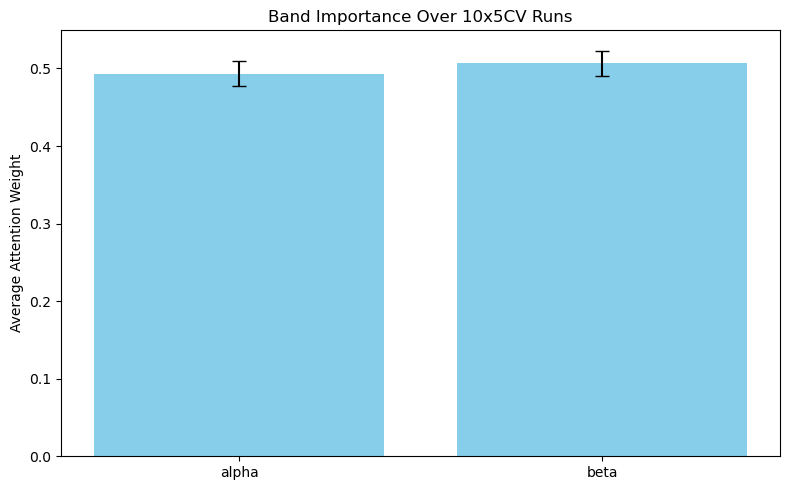

In [6]:
import torch
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from joblib import Parallel, delayed

# Example dataset (replace with your real dynamic_alpha, dynamic_beta)
dataset = list(zip(dynamic_alpha, dynamic_beta))
band_names = ['alpha', 'beta']


# ---- One run of cross-validation ----
def single_run(run, dataset, band_names):
    print(f"\n======= Run {run+1} =======")

    final_model, _, _, _, cv_results = train_with_cross_validation(
        dataset, num_epochs=100, n_folds=5, band_names=band_names
    )

    # Save results for this run
    os.makedirs("results", exist_ok=True)
    torch.save(cv_results['best_fold_metrics'], f"results/best_fold_metrics_run{run+1}.pt")
    torch.save(final_model.state_dict(), f"results/final_model_run{run+1}.pt")

    return cv_results


# ---- Multiple cross-validations with parallel CPUs ----
def run_multiple_cross_validations(dataset, num_runs=10, band_names=None, n_jobs=-1):
    # Run in parallel across CPUs
    results = Parallel(n_jobs=n_jobs)(
        delayed(single_run)(run, dataset, band_names) for run in range(num_runs)
    )

    all_avg_band_importances = []
    all_metrics = {
        'avg_f1': [], 
        'avg_accuracy': [], 
        'avg_recall': [], 
        'avg_precision': [], 
        'f1_std': []
    }

    for cv_results in results:
        # Band importances
        if cv_results['avg_band_importance'] is not None:
            all_avg_band_importances.append(
                list(cv_results['avg_band_importance'].values())
            )
        # Metrics
        for metric in all_metrics.keys():
            all_metrics[metric].append(cv_results[metric])

    # Aggregated results
    print("\n======= Aggregated Results After Runs =======")
    pretty_names = {
        'avg_f1': 'F1',
        'avg_accuracy': 'Accuracy',
        'avg_recall': 'Recall',
        'avg_precision': 'Precision',
        'f1_std': 'F1 Std',
    }

    for metric, values in all_metrics.items():
        mean_val = np.mean(values)
        std_val = np.std(values)
        name = pretty_names.get(metric, metric)
        print(f"{name}: {mean_val:.4f} ± {std_val:.4f}")

    # Band importance aggregation
    if all_avg_band_importances:
        avg_band_importances = np.mean(all_avg_band_importances, axis=0)
        std_band_importances = np.std(all_avg_band_importances, axis=0)
        print("\nAverage Band Importance Across Runs:")
        for i, band_name in enumerate(band_names):
            print(f"{band_name}: {avg_band_importances[i]:.4f} ± {std_band_importances[i]:.4f}")

    return all_metrics, all_avg_band_importances


# ---- Save results ----
def save_results_to_csv(run_metrics, all_band_importances, band_names, output_dir="results"):
    os.makedirs(output_dir, exist_ok=True)

    pd.DataFrame(run_metrics).to_csv(
        os.path.join(output_dir, "10x5cv_metrics.csv"), index=False
    )
    if all_band_importances:
        pd.DataFrame(all_band_importances, columns=band_names).to_csv(
            os.path.join(output_dir, "10x5cv_band_importance.csv"), index=False
        )

    print(f"\n📁 Results saved in '{output_dir}' folder.")


# ---- Plot band importance ----
def plot_band_importance(csv_path):
    df = pd.read_csv(csv_path)
    means = df.mean().values
    stds = df.std().values
    bands = df.columns.tolist()

    plt.figure(figsize=(8, 5))
    plt.bar(bands, means, yerr=stds, capsize=5, color='skyblue')
    plt.ylabel("Average Attention Weight")
    plt.title("Band Importance Over 10x5CV Runs")
    plt.tight_layout()
    plt.savefig("results/band_importance_plot.png")
    plt.show()


# ---- Main ----
if __name__ == "__main__":
    band_names = ['alpha', 'beta'] 
    all_metrics, all_band_importances = run_multiple_cross_validations(
        dataset, band_names=band_names, num_runs=10, n_jobs=-1
    )
    save_results_to_csv(all_metrics, all_band_importances, band_names)
    plot_band_importance("results/10x5cv_band_importance.csv")
